In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import string

In [2]:
# Charger les données d'entraînement et de test
train_data = pd.read_csv('sign_language_train.csv')
test_data = pd.read_csv('sign_language_test.csv')

In [3]:
print("Aperçu des premières lignes du dataset d'entraînement :")
print(train_data.head())

Aperçu des premières lignes du dataset d'entraînement :
   label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0      3     107     118     127     134     139     143     146     150   
1      6     155     157     156     156     156     157     156     158   
2      2     187     188     188     187     187     186     187     188   
3      2     211     211     212     212     211     210     211     210   
4     13     164     167     170     172     176     179     180     184   

   pixel9  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780  \
0     153  ...       207       207       207       207       206       206   
1     158  ...        69       149       128        87        94       163   
2     187  ...       202       201       200       199       198       199   
3     210  ...       235       234       233       231       230       226   
4     185  ...        92       105       105       108       133       163   

   pixel781  pixel

In [4]:
print(f"Nombre total d'images dans le dataset d'entraînement : {train_data.shape[0]}")
print(f"Nombre total d'images dans le dataset de test : {test_data.shape[0]}\n")

print(f"Dimensions des images : {train_data.shape[1] - 1} pixels par image (28x28)")

# Nombre d'exemples par classe (lettre)
classes_train = train_data.iloc[:, 0].value_counts().sort_index()
print("\nDistribution des classes dans le dataset d'entraînement :")
print(classes_train)

Nombre total d'images dans le dataset d'entraînement : 27455
Nombre total d'images dans le dataset de test : 7172

Dimensions des images : 784 pixels par image (28x28)

Distribution des classes dans le dataset d'entraînement :
label
0     1126
1     1010
2     1144
3     1196
4      957
5     1204
6     1090
7     1013
8     1162
10    1114
11    1241
12    1055
13    1151
14    1196
15    1088
16    1279
17    1294
18    1199
19    1186
20    1161
21    1082
22    1225
23    1164
24    1118
Name: count, dtype: int64


On remarque qu'il n'y a-t-il pas de label pour les lettres 9 et 25, on ne représente donc que 24 lettres différentes dans les données d'entrainement ! Il s'agit des lettres "J" et "Z", surprenant.

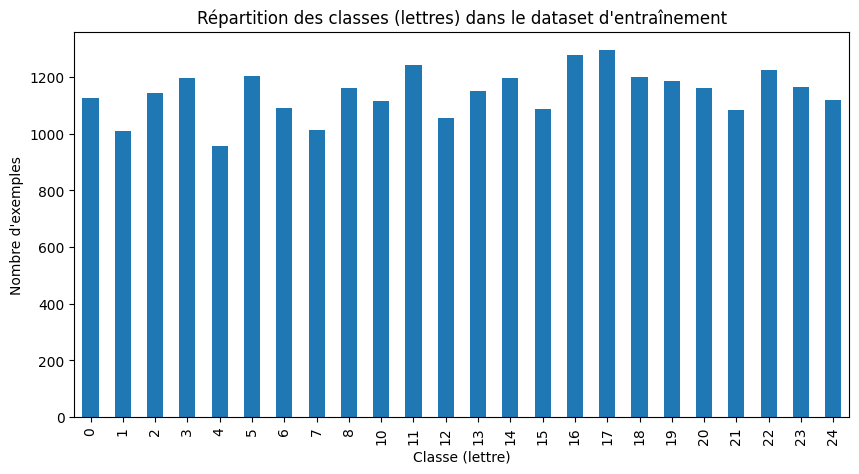

In [5]:
# Graphique pour visualiser la répartition des classes
plt.figure(figsize=(10, 5))
classes_train.plot(kind='bar')
plt.title("Répartition des classes (lettres) dans le dataset d'entraînement")
plt.xlabel("Classe (lettre)")
plt.ylabel("Nombre d'exemples")
plt.show()

In [6]:
# Mapping pour enlever les classes 9 et 25 (on fait un décalage)
def reindex_labels(df):
    df['label'] = df['label'].apply(lambda x: x if x < 9 else (x - 1 if x < 25 else x - 2))
    return df

# Appliquer la fonction
train_data = reindex_labels(train_data)
test_data = reindex_labels(test_data)

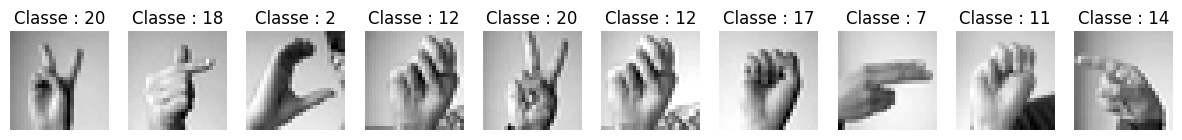

In [7]:
# Reformattage des images pour les interpréter comme des matrices 28x28
X_train = train_data.iloc[:, 1:].values.reshape(-1, 28, 28)
y_train = train_data.iloc[:, 0].values

# Afficher images du dataset d'entraînement
def afficher_images_aleatoires(X, y, n=10):
    plt.figure(figsize=(15, 5))
    for i in range(n):
        index = np.random.randint(0, X.shape[0])
        plt.subplot(1, n, i+1)
        plt.imshow(X[index], cmap='gray')
        plt.title(f"Classe : {y[index]}")
        plt.axis('off')
    plt.show()

# Afficher 10 images aléatoires du dataset d'entraînement
afficher_images_aleatoires(X_train, y_train)

Bien que nos examples peuvent sembler être suffisamment contrastés pour voir les distinctions, nous devons nous assurer que la totalité de nos images sont exploitables : 



In [8]:
# Statistiques rapides sur les valeurs des pixels
print(f"\nValeur minimale des pixels dans le dataset d'entraînement : {X_train.min()}")
print(f"Valeur maximale des pixels dans le dataset d'entraînement : {X_train.max()}")
print(f"Valeur moyenne des pixels dans le dataset d'entraînement : {X_train.mean():.2f}")
print(f"Écart-type des pixels dans le dataset d'entraînement : {X_train.std():.2f}")


Valeur minimale des pixels dans le dataset d'entraînement : 0
Valeur maximale des pixels dans le dataset d'entraînement : 255
Valeur moyenne des pixels dans le dataset d'entraînement : 159.29
Écart-type des pixels dans le dataset d'entraînement : 48.77


On a une plage complète de niveaux de gris allant du noir (0) au blanc (255) et une moyenne supérieure à 127.5, on a donc une légère tendance vers des pixels plus clairs en moyenne, dans une plage de pixels. L'écart-type de 48.77 nous laisse penser que les données sont généralement suffisamment contrastées pour qu'on puisse les exploiter.

Commençons la préparation des données :

In [9]:
# Tableau 1D de 784 valeurs par ligne [154,265,234,...]
X_train = train_data.iloc[:, 1:].values
y_train = train_data.iloc[:, 0].values
X_test = test_data.iloc[:, 1:].values
y_test = test_data.iloc[:, 0].values

print(X_test)

# - Normalisation des valeurs des pixels
# - Ajout d'un canal -> reshape sous forme de 3-uple (28, 28, v) : chaque image => [[[valeurgris_pixel]x28]x28]
# assure que le CNN reconnaisse niveau de gris avec un seul canal
X_train = X_train.reshape(-1, 28, 28, 1).astype('float32') / 255
X_test = X_test.reshape(-1, 28, 28, 1).astype('float32') / 255

print(y_test)
print(list(set(y_test)))

print(X_test)


[[149 149 150 ... 112 120 107]
 [126 128 131 ... 184 182 180]
 [ 85  88  92 ... 225 224 222]
 ...
 [190 191 190 ... 211 209 208]
 [201 205 208 ...  67  70  63]
 [173 174 173 ... 195 193 192]]
[6 5 9 ... 2 4 2]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
[[[[0.58431375]
   [0.58431375]
   [0.5882353 ]
   ...
   [0.5882353 ]
   [0.5882353 ]
   [0.58431375]]

  [[0.5882353 ]
   [0.5882353 ]
   [0.5882353 ]
   ...
   [0.5921569 ]
   [0.5882353 ]
   [0.5921569 ]]

  [[0.5882353 ]
   [0.5921569 ]
   [0.5921569 ]
   ...
   [0.5921569 ]
   [0.5921569 ]
   [0.59607846]]

  ...

  [[0.27058825]
   [0.27058825]
   [0.3019608 ]
   ...
   [0.45490196]
   [0.44313726]
   [0.4627451 ]]

  [[0.2901961 ]
   [0.29411766]
   [0.29803923]
   ...
   [0.43137255]
   [0.45490196]
   [0.44313726]]

  [[0.29411766]
   [0.2901961 ]
   [0.2901961 ]
   ...
   [0.4392157 ]
   [0.47058824]
   [0.41960785]]]


 [[[0.49411765]
   [0.5019608 ]
   [0.5137255 ]
   ...
   [0.521

In [10]:
# One-hot pour CNN et Loss (qui compare vecteurs aux prédictions)
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)

One-hot encoding des labels -> Traiter chaque classe de manière distincte et indépendante

In [18]:
import time 
start_time = time.time()  # Début de la mesure

# Modèle CNN
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(24, activation='softmax')
])



# Compiler le modèle
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entraîner le modèle
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=64)


# Évaluer le modèle
test_loss, test_acc = model.evaluate(X_test, y_test)

end_time = time.time()  # Fin de la mesure
training_time = end_time - start_time  # Temps total d'apprentissage

# Afficher le temps d'apprentissage en secondes
print(f"Temps d'apprentissage total : {training_time:.2f} secondes")


c:\Users\steve_ao846tt\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
429/429 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.3009 - loss: 2.3421 - val_accuracy: 0.7936 - val_loss: 0.6808
Epoch 2/10
429/429 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.7967 - loss: 0.6072 - val_accuracy: 0.8938 - val_loss: 0.3345
Epoch 3/10
429/429 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.8970 - loss: 0.3086 - val_accuracy: 0.9145 - val_loss: 0.2410
Epoch 4/10
429/429 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9353 - loss: 0.1974 - val_accuracy: 0.9244 - val_loss: 0.2170
Epoch 5/10
429/429 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9579 - loss: 0.1284 - val_accuracy: 0.9430 - val_loss: 0.1723
Epoch 6/10
429/429 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9696 - loss: 0.0952 - val_accuracy: 0.9240 - val_loss: 0.2559
Epoch 7/10
429/429 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9741 - loss: 0.0794 - val_accuracy: 0.9387 - val_loss: 0.1987
Epoch 8/10
429/429 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9737 - loss: 0.0771 - val_accu

Loss sur le test: 0.3020697832107544
Accuracy sur le test: 0.911600649356842


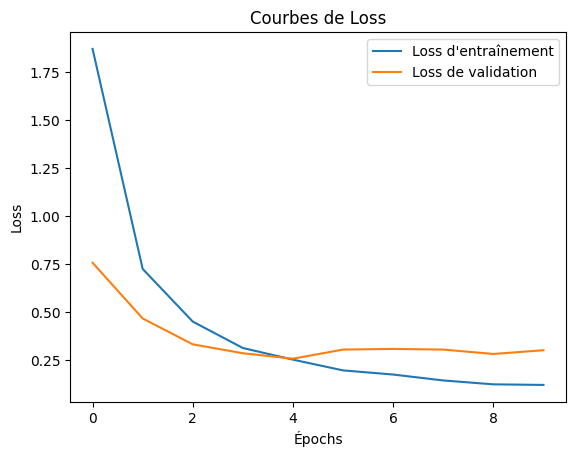

In [12]:

# Afficher les résultats
print(f'Loss sur le test: {test_loss}')
print(f'Accuracy sur le test: {test_acc}')

# Graphique 1 : Courbes de loss
plt.figure()  # Crée une nouvelle figure pour la loss
plt.plot(history.history['loss'], label="Loss d'entraînement")
plt.plot(history.history['val_loss'], label="Loss de validation")
plt.title('Courbes de Loss')
plt.xlabel('Épochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


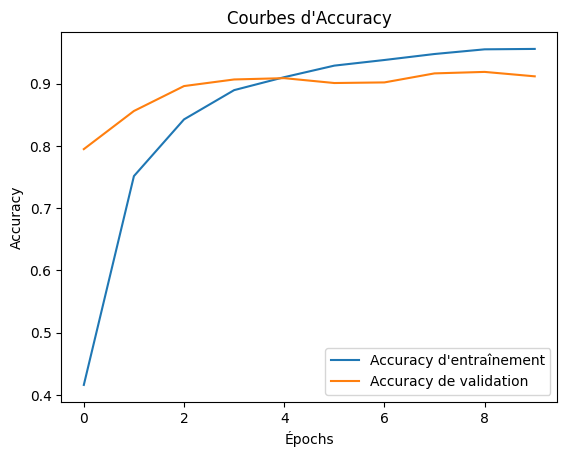

In [13]:

# Graphique 2 : Courbes d'accuracy
plt.figure()  # Crée une nouvelle figure pour l'accuracy
plt.plot(history.history['accuracy'], label="Accuracy d'entraînement")
plt.plot(history.history['val_accuracy'], label="Accuracy de validation")
plt.title('Courbes d\'Accuracy')
plt.xlabel('Épochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


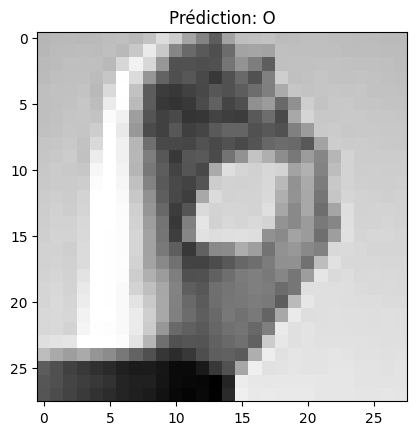

In [14]:
# Création du mapping de l'index (0-24) vers les lettres de l'alphabet (sans J et Z)
alphabet = list(string.ascii_uppercase)
alphabet.remove('J')
alphabet.remove('Z')
index_to_letter = {i: letter for i, letter in enumerate(alphabet)}

# Sélectionner une image aléatoire dans les données de test
index = np.random.randint(0, X_test.shape[0])
image = X_test[index].reshape(28, 28)  # Si tes images sont en format 28x28

# Prédire la classe de l'image
predicted_label = np.argmax(model.predict(np.expand_dims(X_test[index], axis=0)))

# Obtenir la lettre correspondant à l'index prédit
predicted_letter = index_to_letter[predicted_label]

# Afficher l'image et la prédiction (lettre)
plt.imshow(image, cmap='gray')
plt.title(f'Prédiction: {predicted_letter}')
plt.show()

In [15]:
# Sauvegarder le modèle
model.save('model.h5')